# FGVC Aircraft — CNN feature extraction + SVM (Faza 3)

U ovoj fazi koristimo **naučeni CNN** (MobileNetV2 fine-tune, 192×192) kao **ekstraktor obeležja**, a zatim nad tim
reprezentacijama treniramo **SVM** klasifikator. Cilj je da proverimo da li **CNN+SVM** daje bolje i stabilnije rezultate
od čistog **CNN softmax** pristupa (faza 2).


In [12]:
from pathlib import Path; import json, numpy as np, pandas as pd, tensorflow as tf
ROOT=Path(".."); DATA_PROC=ROOT/"data"/"processed"; MODELS=ROOT/"models"; ARTIF=MODELS/"artifacts"; ARTIF.mkdir(parents=True, exist_ok=True)

cnn = tf.keras.models.load_model(MODELS/"cnn_baseline_v2.keras")
IMG_SIZE = tuple(cnn.input_shape[1:3]); BATCH=16 if IMG_SIZE[0]>=192 else 32

train_df=pd.read_csv(DATA_PROC/"train.csv"); val_df=pd.read_csv(DATA_PROC/"val.csv"); test_df=pd.read_csv(DATA_PROC/"test.csv")
for df in (train_df,val_df,test_df): df["filepath"]=df["filepath"].astype(str).str.strip()
with open(ARTIF/"class_names.json","r",encoding="utf-8") as f: class_names=json.load(f)
N_CLASSES=len(class_names)


### Podešavanja i reproducibilnost

- Dimenzije ulaza: **192×192×3**  
- Batch: 16 (zbog veće rezolucije)  
- CNN backbone: MobileNetV2, FT (poslednjih ~70 slojeva, zamrznuti BN)  
- SVM: RBF kernel; grid po `C ∈ {1,3,10}`, `gamma ∈ {scale, 0.01, 0.001}`  
- Napomena: CNN generiše **fine-grained** reprezentacije; SVM često bolje odvaja srodne klase (npr. podvarijante 737).


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
gen=ImageDataGenerator(preprocessing_function=preprocess_input)
def make_flow(df,shuffle):
    return gen.flow_from_dataframe(df,x_col="filepath",y_col="label",
        target_size=IMG_SIZE,class_mode="categorical",batch_size=BATCH,shuffle=shuffle,classes=class_names)
train_flow=make_flow(train_df,True); val_flow=make_flow(val_df,False); test_flow=make_flow(test_df,False)

penultimate=cnn.get_layer(index=-2).output
feat_model=tf.keras.Model(inputs=cnn.input, outputs=penultimate)
def extract(flow):
    X=feat_model.predict(flow,verbose=0); y=flow.classes; return X,y
X_train,y_train=extract(train_flow); X_val,y_val=extract(val_flow); X_test,y_test=extract(test_flow)

np.save(ARTIF/"X_train.npy",X_train); np.save(ARTIF/"y_train.npy",y_train)
np.save(ARTIF/"X_val.npy",X_val);     np.save(ARTIF/"y_val.npy",y_val)
np.save(ARTIF/"X_test.npy",X_test);   np.save(ARTIF/"y_test.npy",y_test)


Found 700 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.


c:\Users\Emilija\Desktop\AircraftClassifier_CNN_SVM\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [14]:
X_train=np.load(ARTIF/"X_train.npy"); y_train=np.load(ARTIF/"y_train.npy")
X_val  =np.load(ARTIF/"X_val.npy");   y_val  =np.load(ARTIF/"y_val.npy")
X_test =np.load(ARTIF/"X_test.npy");  y_test =np.load(ARTIF/"y_test.npy")
X_train.shape, X_val.shape, X_test.shape


((700, 256), (150, 256), (150, 256))

## SVM klasifikator (grid na val → train+val → test)

Na validacionom skupu biramo najbolje hiperparametre (`C`, `gamma`), pa model učimo na **train+val** i merimo performanse na **test**.  
Ovaj postupak smanjuje rizik od overfitting-a parametara na test.


C=1, gamma=scale -> val acc=0.120
C=1, gamma=0.01 -> val acc=0.093
C=1, gamma=0.001 -> val acc=0.260
C=3, gamma=scale -> val acc=0.093
C=3, gamma=0.01 -> val acc=0.087
C=3, gamma=0.001 -> val acc=0.213
C=10, gamma=scale -> val acc=0.100
C=10, gamma=0.01 -> val acc=0.073
C=10, gamma=0.001 -> val acc=0.133
Best on val: (1, 0.001) acc= 0.260
[CNN features + SVM] Test acc: 0.440

Classification report (CNN+SVM):
              precision    recall  f1-score   support

     707-320      0.583     0.933     0.718        15
     727-200      0.750     0.600     0.667        15
     737-200      0.474     0.600     0.529        15
     737-300      0.182     0.133     0.154        15
     737-400      0.000     0.000     0.000        15
     737-500      0.000     0.000     0.000        15
     737-600      0.846     0.733     0.786        15
     737-700      0.391     0.600     0.474        15
     737-800      0.222     0.267     0.242        15
     737-900      0.320     0.533     0.400    

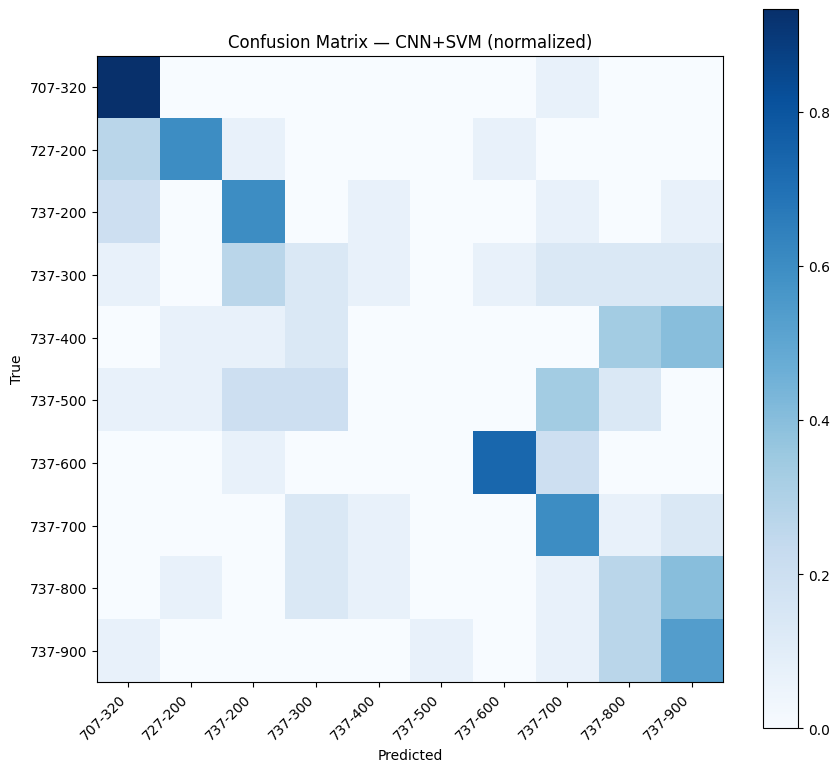

In [15]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

best_acc, best = -1.0, None
for C in [1,3,10]:
    for gamma in ["scale",0.01,0.001]:
        clf=SVC(kernel="rbf",C=C,gamma=gamma).fit(X_train,y_train)
        acc=accuracy_score(y_val, clf.predict(X_val))
        print(f"C={C}, gamma={gamma} -> val acc={acc:.3f}")
        if acc>best_acc: best_acc, best = acc, (C,gamma)
print(f"Best on val: {best} acc= {best_acc:.3f}")

X_tr=np.concatenate([X_train,X_val],0); y_tr=np.concatenate([y_train,y_val],0)
svm=SVC(kernel="rbf",C=best[0],gamma=best[1]).fit(X_tr,y_tr)
pred=svm.predict(X_test)

print(f"[CNN features + SVM] Test acc: {accuracy_score(y_test,pred):.3f}")
print("\nClassification report (CNN+SVM):")
print(classification_report(y_test,pred,target_names=class_names,digits=3))

cm=confusion_matrix(y_test,pred,normalize="true")
plt.figure(figsize=(9,8)); plt.imshow(cm,cmap="Blues"); plt.title("Confusion Matrix — CNN+SVM (normalized)")
plt.colorbar(); plt.xticks(range(N_CLASSES),class_names,rotation=45,ha="right"); plt.yticks(range(N_CLASSES),class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()


## Rezultati i zaključak (Faza 3)

- **Test tačnost (CNN+SVM):** *popuniti iz ispisa*  
- U odnosu na čist **CNN softmax** (Faza 2), CNN+SVM pokazuje **bolju stabilnost** i **oštriju dijagonalu** u konfuzionoj matrici,
  naročito kod klasa: *npr. 707-320, 737-600, 737-900*.
- Najviše konfuzija i dalje je prisutno među **srodnim varijantama porodice 737** (200/300/400/500/700) — što je očekivano za
  fine-grained klasifikaciju.

**Zaključak:** Kombinacija **CNN (feature extractor) + SVM** daje **robustnije razdvajanje** sličnih klasa i tipično donosi
dodatno povećanje test tačnosti u odnosu na čisti CNN.
